<a href="https://colab.research.google.com/github/Emma-Ok/PageRank/blob/main/Emmanuel_pageRank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Page Rank


In [ ]:
from networkx.algorithms.shortest_paths.unweighted import predecessor
from networkx.utils.misc import nodes_equal
import networkx as nx
import pandas as pd

# Creacion del grafo que representa una pagina web
class Webmatrix:
  _dfMatrix = None
  def __init__(self,nodes, edges):
    self._createGraph_(nodes, edges) # create the graph.

  # create the graph.
  def _createGraph_(self, nodes, edges):
    self._G  = nx.DiGraph()
    self._G.add_nodes_from(nodes)
    self._G.add_edges_from(edges)

  #Remueve un nodo del grafo
  def remove_node(self,node):
    self._G.remove_node(node)

  # busca los nodos muertos
  def find_DeadEnds_(self):
    DeadEnds = []
    nodes = list(self._G.nodes())
    for node in nodes:
      degree = self._G.out_degree(node)
      if degree == 0:
         predecessor = list(self._G.predecessors(node))
         DeadEnds.append([node, predecessor])
    return DeadEnds

  #Trae la lista de nodos del grafo
  def getNodes(self):
    return list(self._G.nodes)

  # Construyte la matriz compacta del grafo
  def build_matrix(self):
    nodes = self.getNodes()
    degrees = []
    dest = []
    for node in nodes:
      degree = self._G.out_degree(node)
      if degree > 0:
          degrees.append(degree)
          dest.append(list(self._G.successors(node)))
      else:
        nodes.remove(node)
    self._dfMatrix = pd.DataFrame({'degreed':degrees  , 'dest': dest},index=nodes)
    return self._dfMatrix

  # Grafica un grafo
  def _view_(self):
        nx.draw(self._G, with_labels=True, font_color='white', node_color="purple", edgecolors="blue", font_size=8,  node_size= 900, font_weight="bold")

In [ ]:
from numpy import False_
from matplotlib.lines import VertexSelector
from pandas._libs.tslibs import vectorized
import copy

#Clase para calcular el page rank de un grafo web
class PageRank:
  pr = None # variable que guarde el page rank de la pagina
  _Webmatrix_deep = None # grafo una vez eliminado los nodos muertos
  _deadEnds = None # lista con los nodos muerto y sus antecesores

  #Metodo constructor que inicializa el grafo y web y el diccionario page rank
  def __init__(self, webmatrix, Beta):
    self._Webmatrix = webmatrix
    self.getPageRank(Beta)


 ## Obtiene grafo despues de eliminar los deadEnd
  def _DropDeadEnds_(self):
    if self._deadEnds == None:
      self._deadEnds = []
      self._Webmatrix_deep = copy.deepcopy(self._Webmatrix)
      sw = True
      while sw:
        deadEnds = self._Webmatrix_deep.find_DeadEnds_()
        if (deadEnds):
          for deadEnd in deadEnds:
            self._deadEnds.append(deadEnd)
            self._Webmatrix_deep.remove_node(deadEnd[0])
        else:
          sw = False
    return self._deadEnds

  #construye el diccionario page rank
  def createPageRank(self):
     pr = {}
     nodes = self._Webmatrix.getNodes()
     for node in nodes:
       pr[node] = 0
     return pr

  #Calcula taxation de un grafo
  def Taxation(self, Beta, S = None):

    # Matriz de transicion
    M = self._Webmatrix_deep.build_matrix()
    # vector de probabilidades
    n = len(self._Webmatrix_deep.getNodes())
    V = self.getVini(S)
    e = self.getVini(S)
    sw = True

    while(sw):
      Vpost = self.getV(M,V,Beta,e) #
      if self.evaluateCondition(V,Vpost, 0.000001):
        sw = False
      V = Vpost

    return Vpost
# vector inicial de acuerdo si se calcular pageRank o trustRank
# S nodos de los temas de interes o nodos de confianza
  def getVini(self,S):
    nodes = self._Webmatrix_deep.getNodes()
    n = len(self._Webmatrix_deep.getNodes())
    if S == None:
      return [1/n]*n
    else:
      v = [0]*n
      lenS = len(S)
      for node in S:
        index = nodes.index(node)
        v[index] = 1/lenS
      return v

  #Calcula el page rank
  def getPageRank(self, Beta):
    if self.pr == None:
      self.pr = self.createPageRank()
    #1. DropDeand
    self._DropDeadEnds_()
    #2. Taxation
    Vpost = self.Taxation(Beta)
    M = self._Webmatrix_deep.build_matrix()
    i = 0
    for row in M.itertuples():
      self.pr[row.Index] +=Vpost[i]
      i += 1
    #3. Compute page Rank
    self.computePageRank()
    return self.pr



  def computePageRank(self):
     M = self._Webmatrix.build_matrix();
     i = len(self._deadEnds) -1
     while i > -1:
       node = self._deadEnds[i][0]
       predecesors = self._deadEnds[i][1]
       for predesor in predecesors:
         index =M.index.get_loc(predesor)
         prob = 1/M.iloc[index].degreed
         self.pr[node] += prob*self.pr[predesor]
       i -= 1
     return self.pr

  #Calcula V' = B*M*V + (1-Beta)*e/n
  def getV(self, M,V,Beta,e):
      vpost= self. multiplicationMatrixVector(M,V)
      for x in range(0, len(vpost)):
        vpost[x] = Beta*vpost[x] + (1-Beta)*e[x]
      return vpost

  #multiplicacion matriz vector vpost = M*V
  def multiplicationMatrixVector(self,M,V):
     n = len(V)
     vpost = [0]*n
     for row in M.itertuples():
          x = 1/row.degreed
          index =  M.index.get_loc(row.Index)
          y = V[index]
          value = x*y
          for node in row.dest:
            i = M.index.get_loc(node)
            vpost[i] += value
     return vpost

  #Evalua la codicion de cierre para frenar las comparaciones entre v y v'
  def evaluateCondition(self,v1,v2,eps):
    isClosed = True
    i=0
    while (i <len(v1)) :
      if abs(v1[i]-v2[i]) > eps :
       i = len(v1)
       isClosed = False
      i+=1
    return isClosed
# S paginas confiables
  def masaSpam(self, Beta, S):

    nodes = self._Webmatrix.getNodes()
    pageRanks = []
    trustRanks = []
    spamMass = []
    tr = self.TrusRank(Beta,S)

    masa_spam = {}
    for page in self.pr:
      masa_spam[page] = (self.pr[page] - tr[page]) / self.pr[page]

      pageRanks.append(self.pr[page])
      trustRanks.append(tr[page])
      spamMass.append(masa_spam[page])


    calculationSpamMass = pd.DataFrame({'Node':nodes  , 'PageRank': pageRanks, 'TrustRank': trustRanks, 'Spam Mass': spamMass})

    return calculationSpamMass

  #def TrusRank(self, tolerancia, Beta, umbral_confianza):

  def TrusRank(self,Beta, S):
    tr = self.createPageRank()
    #Taxatio para obtener el vector de probabilidad posterior
    Vpost = self.Taxation( Beta, S)
    M = self._Webmatrix_deep.build_matrix()
    i = 0
    for row in M.itertuples():
      tr[row.Index] +=Vpost[i]
      i += 1
    return tr



In [ ]:
#Testion pageRank de acuerdo al ejemplo dado en clase
nodes = ["page-1","page-2","page-3","page-4", "page-5"]
edges = [("page-1","page-2"), ("page-1","page-3"),("page-1","page-4"), ("page-2","page-1"),("page-2","page-4"),("page-3","page-5"),("page-4","page-3"),("page-4","page-2")]
web = Webmatrix(nodes,edges)
pageRank = PageRank(web, 0.8)


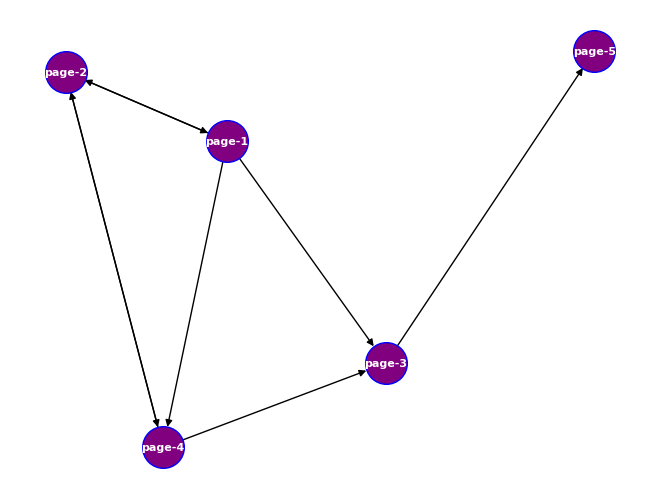

In [ ]:
web._view_()

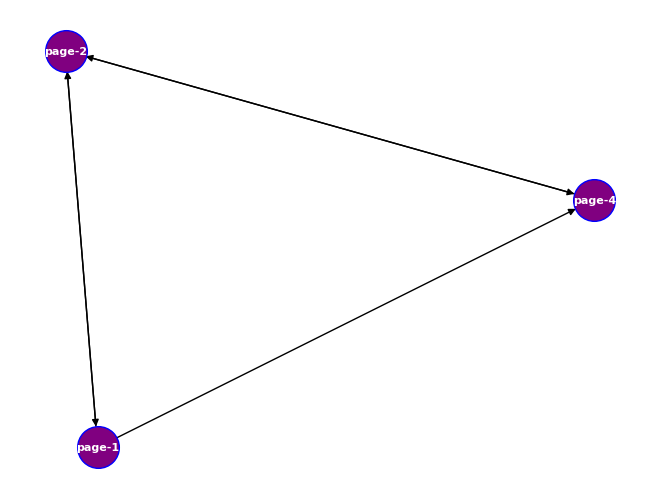

In [ ]:
pageRank._Webmatrix_deep._view_()

In [ ]:
print(web.build_matrix())

        degreed                      dest
page-1        3  [page-2, page-3, page-4]
page-2        2          [page-1, page-4]
page-3        1                  [page-5]
page-4        2          [page-3, page-2]


In [ ]:
pageRank.pr

{'page-1': 0.23809549374805336,
 'page-2': 0.42857117291861335,
 'page-3': 0.24603183124935113,
 'page-4': 0.33333333333333337,
 'page-5': 0.24603183124935113}

In [ ]:
#Solucion probada
nodes = ["page-1","page-2","page-3","page-4"]
edges = [("page-1","page-2"), ("page-1","page-3"),("page-1","page-4"), ("page-2","page-1"),("page-2","page-4"),("page-3","page-1"),("page-4","page-3"),("page-4","page-2")]
web = Webmatrix(nodes,edges)
pageRank = PageRank(web, 1)
print(pageRank.pr)


{'page-1': 0.33333301544189453, 'page-2': 0.22222232818603516, 'page-3': 0.22222232818603516, 'page-4': 0.22222232818603516}


In [ ]:
print(pageRank.masaSpam(0.8, ["page-2","page-4" ]))

     Node  PageRank  TrustRank  Spam Mass
0  page-1  0.333333   0.257143   0.228571
1  page-2  0.222222   0.280952  -0.264285
2  page-3  0.222222   0.180952   0.185714
3  page-4  0.222222   0.280952  -0.264285


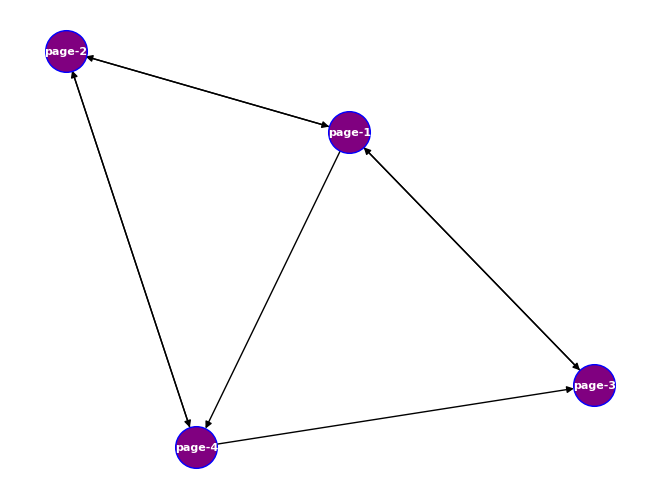

In [ ]:
web._view_()

In [ ]:
print(web.build_matrix())

        degreed                      dest
page-1        3  [page-2, page-3, page-4]
page-2        2          [page-1, page-4]
page-3        1                  [page-1]
page-4        2          [page-3, page-2]


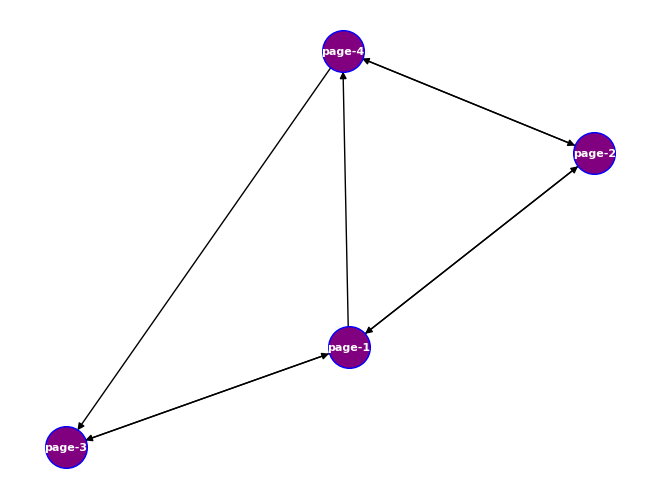

In [ ]:
pageRank._Webmatrix_deep._view_()


In [ ]:
pageRank._Webmatrix_deep.build_matrix()

,degreed,dest
page-1,3,"[page-2, page-3, page-4]"
page-2,2,"[page-1, page-4]"
page-3,1,[page-1]
page-4,2,"[page-3, page-2]"


In [ ]:
pageRank.pr

{'page-1': 0.33333301544189453,
 'page-2': 0.22222232818603516,
 'page-3': 0.22222232818603516,
 'page-4': 0.22222232818603516}

In [ ]:
#Solucion probada
sport_nodes = ["page-1","page-2","page-3","page-4"]
sport_edges = [("page-1","page-2"), ("page-1","page-3"),("page-1","page-4"), ("page-2","page-1"),("page-2","page-4"),("page-3","page-1"),("page-4","page-3"),("page-4","page-2")]
web = Webmatrix(sport_nodes,sport_edges)
pageRank = PageRank(web, 1)
print("Deportes")
print(pageRank.masaSpam(0.8, ["page-2","page-1" ]))

Deportes
     Node  PageRank  TrustRank  Spam Mass
0  page-1  0.333333   0.348980  -0.046940
1  page-2  0.222222   0.274150  -0.233673
2  page-3  0.222222   0.174150   0.216327
3  page-4  0.222222   0.202721   0.087756


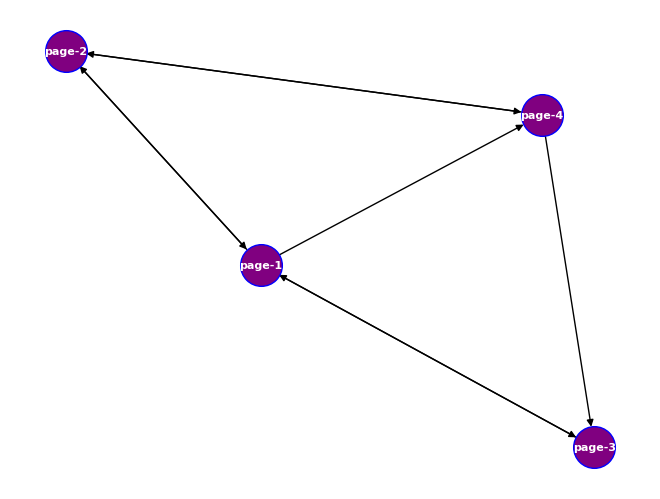

In [ ]:
web._view_()

In [ ]:
business_nodes = ["page-1","page-2","page-3","page-4", "page-5"]
business_edges = [("page-1","page-2"), ("page-1","page-3"),("page-1","page-4"), ("page-2","page-1"),("page-2","page-4"),("page-4","page-2"),("page-4","page-3"), ("page-3","page-5") ]
web = Webmatrix(business_nodes,business_edges)
pageRank = PageRank(web, 1)
print("Deportes")
print(pageRank.masaSpam(0.8, ["page-2","page-4" ]))

Deportes
     Node  PageRank  TrustRank  Spam Mass
0  page-1  0.222222   0.183674   0.173468
1  page-2  0.444445   0.459183  -0.033162
2  page-3  0.240741   0.000000   1.000000
3  page-4  0.333333   0.357143  -0.071429
4  page-5  0.240741   0.000000   1.000000


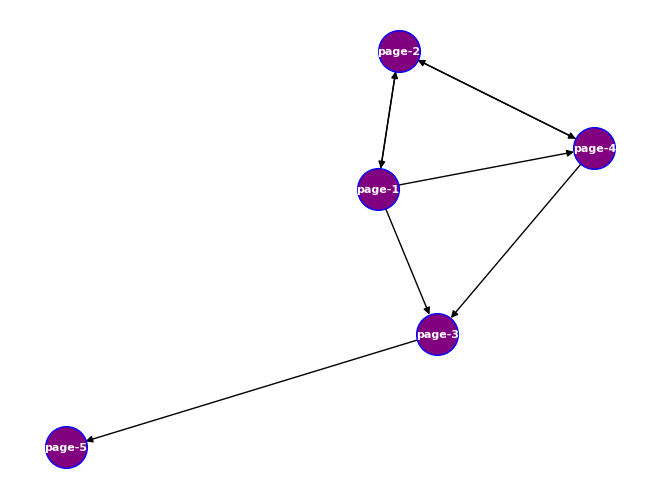

In [ ]:
web._view_()

In [ ]:
import networkx as nx

def trust_rank_sensitive(nodes, edges, trust_levels, trusted_pages,  trust_threshold=0.001, topic_sensitive=False, topic_weights=None):
    # Creamos el grafo
    webMatrix = Webmatrix(nodes,edges)
    Web = webMatrix._G
    pagerank = PageRank(web)
    pagerank.getPageRank(0.8)
    # Asignamos valores iniciales a cada página
    N = len(nodes)
    initial_value = 1/N

    trustrank = {node: initial_value for node in nodes}

    # Seleccionamos el conjunto de páginas de confianza y las etiquetamos como "confiables"
    for node, trust_level in trust_levels.items():
        if trust_level > trust_threshold:
            trustrank[node] = 1

    for node in trusted_pages:
        trustrank[node] = 1

    # Iteramos el algoritmo de TrustRank varias veces
    max_iterations = 100
    tolerance = 1.0e-6
    for i in range(max_iterations):
        old_trustrank = dict(trustrank) #se guarda una copia del TrustRank anterior
        for node in nodes:
            in_links = Web.in_edges(node)  #Se obtiene los encales entrantes
            trustrank[node] = (1 - d) / d
            for (in_node, _) in in_links:
                if trustrank[in_node] >= trust_threshold:
                    if in_node in trusted_pages:
                        trustrank[node] += d * (1 / len(trusted_pages)) * old_trustrank[in_node] #Si el nodo entrante es de confianza, se actualiza
                    else:
                        if topic_sensitive and topic_weights is not None:
                            trustrank[node] += d * topic_weights[in_node] * old_trustrank[in_node] / Web.out_degree(in_node) #si no, se calcula dependiendo de la cantidad de nodos ssalientes
                        else:
                            trustrank[node] += d * (1 - 1 / len(trusted_pages)) * old_trustrank[in_node] / Web.out_degree(in_node)
        if sum(abs(old_trustrank[node] - trustrank[node]) for node in nodes) < tolerance: #Verifica si la diferencia entre el TrustRank anterior y el actual es menor que la tolerancia
            break
    # Calculamos la masa de spam para cada página
     # Calculamos la masa de spam para cada página
    pageR = pageRank.pr()
    masa_spam = {}
    for page in pageR:
        masa_spam[page] = (pageR[page] - trustrank[page]) / pageR[page]

     # Retornamos los resultados
    return  [pageR], trustrank, masa_spam



In [ ]:
import networkx as nx

nodes = ["page-1", "page-2", "page-3", "page-4", "page-5"]
edges = [("page-1", "page-2"), ("page-1", "page-3"), ("page-1", "page-4"),
         ("page-2", "page-1"), ("page-2", "page-4"), ("page-3", "page-1"),
         ("page-4", "page-3"), ("page-4", "page-2"), ("page-5", "page-1")]
trust_levels = {"page-1": 0.9, "page-2": 0.5, "page-3": 0.1, "page-4": 0.8, "page-5": 0.7}
trusted_pages = ["page-1", "page-4"]
d = 0.85
trust_threshold = 0.001
topic_sensitive = False
topic_weights = None
#web = Webmatrix(nodes,edges)
#pagerank = PageRank(web)
#pagerank.getPageRank(0.8)

pagerank, trustrank,  spam_mass = trust_rank_sensitive( nodes, edges, trust_levels, trusted_pages,  trust_threshold, topic_sensitive, topic_weights)

# Imprimimos los resultados
print("Deportes")
print("Page\tPageRank TrustRank Masa de spam")
for page in pagerank:
    print("{}\t{:.3f}\t{:.3f}\t{:.3f}".format(page, pagerank[page], trustrank[page], spam_mass[page]))

TypeError: ignored

In [ ]:
import networkx as nx
nodes = ["page-1","page-2","page-3","page-4", "page-5"]
edges = [("page-1","page-2"), ("page-1","page-3"),("page-1","page-4"), ("page-2","page-1"),("page-2","page-4"),("page-4","page-2"),("page-4","page-3"), ("page-3","page-5") ]
trust_levels = {"page-1": 0.9, "page-2": 0.5, "page-3": 0.9, "page-4": 0.8, "page-5": 0.9}
trusted_pages = ["page-1", "page-4"]
d = 0.85
trust_threshold = 0.001
topic_sensitive = False
topic_weights = None
#web = Webmatrix(nodes,edges)
#pagerank = PageRank(web)
#pagerank.getPageRank(0.8)

pagerank, trustrank,  spam_mass = trust_rank_sensitive( nodes, edges, trust_levels, trusted_pages,  trust_threshold, topic_sensitive, topic_weights)

# Imprimimos los resultados
print("Negocios")
print("Page\tPageRank TrustRank Masa de spam")
for page in pagerank:
    print("{}\t{:.3f}\t{:.3f}\t{:.3f}".format(page, pagerank[page], trustrank[page], spam_mass[page]))

In [ ]:
web._view_()